In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torch as torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset  # Imported Subset
from sklearn.model_selection import train_test_split  # Imported train_test_split
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert images to grayscale if not already
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the images
])

destination_folder = 'combined_data'
# Load the combined dataset
combined_dataset = datasets.ImageFolder(destination_folder, transform=transform)

# Calculate split sizes
total_size = len(combined_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

# Split the combined dataset
indices = list(range(total_size))
np.random.seed(25)  # Ensure reproducibility
np.random.shuffle(indices)

train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]

# Create subset datasets
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, valid_indices)
test_dataset = Subset(combined_dataset, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print dataset sizes
print(f'Total samples: {total_size}')
print(f'Train samples: {train_size}')
print(f'Validation samples: {valid_size}')
print(f'Test samples: {test_size}')

Total samples: 8416
Train samples: 5891
Validation samples: 1262
Test samples: 1263


/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
# DenseNet block
class DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(DenseLayer, self).__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = self.conv1(self.relu1(self.norm1(x)))
        new_features = self.conv2(self.relu2(self.norm2(new_features)))
        if self.drop_rate > 0:
            new_features = nn.functional.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(Transition, self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        return self.pool(x)

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=2):

        super(DenseNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),  # Change input channels to 1
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers=num_layers, num_input_features=num_features, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = nn.functional.relu(features, inplace=True)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

model = DenseNet()
print(model)

DenseNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (block): Sequential(
        (0): DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle

# Check if GPU is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on: {device}')

# Initialize the model, criterion, and optimizer
model = DenseNet().to(device)  # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_val_model(model, train_loader, validation_loader, criterion, optimizer, epochs):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0.0
        total_train = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
            targets = targets.squeeze().long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
                targets = targets.squeeze().long()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        avg_val_loss = val_loss / len(validation_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(validation_accuracy)
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train_val_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

Training on: cuda:0
Epoch 1/10, Loss: 0.4755, Training Accuracy: 78.98%
Validation Loss: 0.4446, Validation Accuracy: 76.31%
Epoch 2/10, Loss: 0.3432, Training Accuracy: 85.84%
Validation Loss: 7.6386, Validation Accuracy: 49.52%
Epoch 3/10, Loss: 0.2771, Training Accuracy: 88.39%
Validation Loss: 0.4952, Validation Accuracy: 82.09%
Epoch 4/10, Loss: 0.2742, Training Accuracy: 89.15%
Validation Loss: 0.4036, Validation Accuracy: 85.74%
Epoch 5/10, Loss: 0.2551, Training Accuracy: 89.95%
Validation Loss: 0.2716, Validation Accuracy: 87.08%
Epoch 6/10, Loss: 0.2167, Training Accuracy: 91.94%
Validation Loss: 0.4350, Validation Accuracy: 87.00%
Epoch 7/10, Loss: 0.2347, Training Accuracy: 90.95%
Validation Loss: 0.1760, Validation Accuracy: 92.95%
Epoch 8/10, Loss: 0.2246, Training Accuracy: 91.90%
Validation Loss: 0.7887, Validation Accuracy: 75.20%
Epoch 9/10, Loss: 0.2032, Training Accuracy: 92.26%
Validation Loss: 0.3467, Validation Accuracy: 85.58%
Epoch 10/10, Loss: 0.1923, Training

In [5]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Ensure device is set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the model in evaluation mode
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []
predicted_probs = []
test_accuracies_early = []
test_losses = []
best_test_accuracy = 0.0

# No gradient calculation needed during testing
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU for further processing
        true_labels.extend(labels.cpu().numpy())  # Move true labels back to CPU for further processing
        predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Store softmax probabilities

# Calculate test accuracy and loss
test_accuracy = 100 * correct_test / total_test
test_loss = test_loss / len(test_loader)

# Storing the test loss values for each batch into a list
test_losses.append(test_loss)
# Similarly storing accuracies into a list
test_accuracies_early.append(test_accuracy)

if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy

# Calculating the precision, recall, and F1 score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {best_test_accuracy:.2f}%')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')


Test Accuracy: 82.26%
Final Precision: 0.8686
Final Recall: 0.8226
Final F1 Score: 0.8275


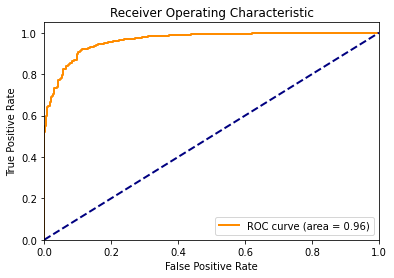

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Convert true_labels to binary format for ROC calculation
true_labels_binary = label_binarize(true_labels, classes=[0, 1])

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels_binary.ravel(), [prob[1] for prob in predicted_probs])
roc_auc = auc(fpr, tpr)

%matplotlib inline

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

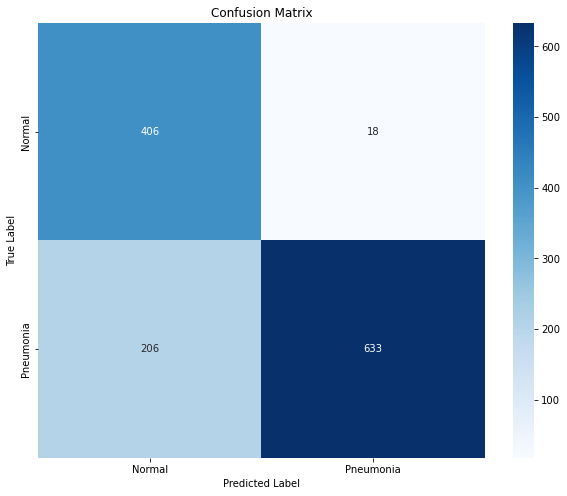

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


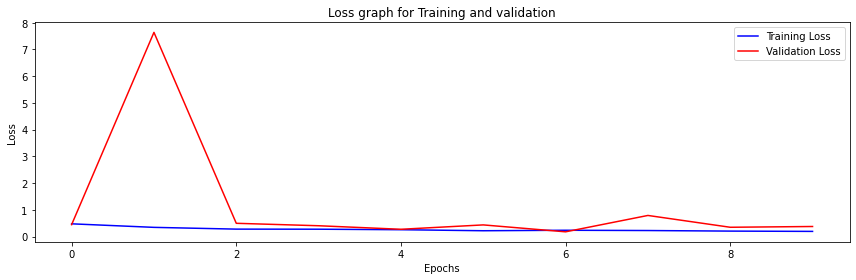

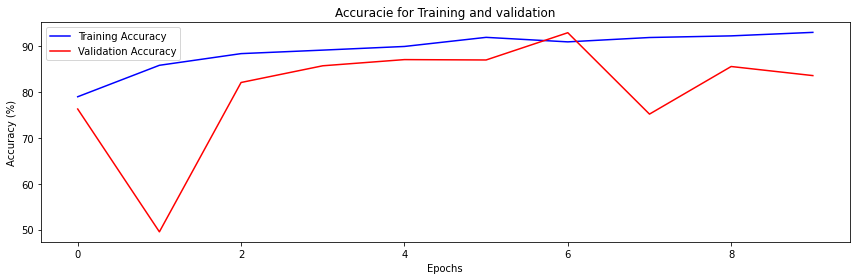

In [13]:
# Plot losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for Training and validation')

plt.tight_layout()
plt.show()


#Plot accuracies
plt.figure(figsize=(12, 4))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracie for Training and validation')

plt.tight_layout()
plt.show()

## Improved DenseNet Model

By adding drop out layers and l2 regularisation

In [14]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(DenseLayer, self).__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = self.conv1(self.relu1(self.norm1(x)))
        new_features = self.conv2(self.relu2(self.norm2(new_features)))
        if self.drop_rate > 0:
            new_features = nn.functional.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(Transition, self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        return self.pool(x)

class Imp_DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0.5, num_classes=2):

        super(Imp_DenseNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),  # Change input channels to 1
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers=num_layers, num_input_features=num_features, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = nn.functional.relu(features, inplace=True)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

model_1 = Imp_DenseNet().to(device)
print(model_1)

Imp_DenseNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (block): Sequential(
        (0): DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001, weight_decay = 0.0005)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on: {device}')

def train_val_model(model, train_loader, validation_loader, criterion, optimizer, epochs, patience):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    no_improvement_count = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0.0
        total_train = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
            targets = targets.squeeze().long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
                targets = targets.squeeze().long()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()
                
        # Calculate validation accuracy and loss
        avg_val_loss = val_loss / len(validation_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1} out of {epochs}')
            break
    
    # Save the best model
    if best_model_state is not None:
        torch.save(best_model_state, 'manishbi_hsriram_swanitha_project_checkpoint2_densenet_imp.pkl')
        print(f'Saved best model with validation loss: {best_val_loss:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

epochs = 15
patience = 2  # Number of epochs with no improvement after which training will be stopped
train_losses, val_losses, train_accuracies, val_accuracies = train_val_model(model_1, train_loader, val_loader, criterion, optimizer, epochs=epochs, patience=patience)

# Load the best model
model_1.load_state_dict(torch.load('manishbi_hsriram_swanitha_project_checkpoint2_densenet_imp.pkl'))

Training on: cuda:0


/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/15, Loss: 0.3278, Training Accuracy: 85.21%
Validation Loss: 0.4220, Validation Accuracy: 78.68%
Epoch 2/15, Loss: 0.2798, Training Accuracy: 87.86%
Validation Loss: 0.3415, Validation Accuracy: 84.15%
Epoch 3/15, Loss: 0.2562, Training Accuracy: 89.34%
Validation Loss: 0.6835, Validation Accuracy: 80.11%
Epoch 4/15, Loss: 0.2336, Training Accuracy: 90.78%
Validation Loss: 0.2788, Validation Accuracy: 92.71%
Epoch 5/15, Loss: 0.2190, Training Accuracy: 91.48%
Validation Loss: 0.2470, Validation Accuracy: 89.38%
Epoch 6/15, Loss: 0.2006, Training Accuracy: 92.16%
Validation Loss: 0.2579, Validation Accuracy: 89.70%
Epoch 7/15, Loss: 0.2023, Training Accuracy: 91.95%
Validation Loss: 0.4014, Validation Accuracy: 83.28%
Early stopping at epoch 7 out of 15
Saved best model with validation loss: 0.2470


<All keys matched successfully>

In [16]:
# Ensure device is set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the model in evaluation mode
model_1.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []
predicted_probs = []
test_accuracies_early = []
test_losses = []
best_test_accuracy = 0.0

# No gradient calculation needed during testing
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU for further processing
        true_labels.extend(labels.cpu().numpy())  # Move true labels back to CPU for further processing
        predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Store softmax probabilities

# Calculate test accuracy and loss
test_accuracy = 100 * correct_test / total_test
test_loss = test_loss / len(test_loader)

# Storing the test loss values for each batch into a list
test_losses.append(test_loss)
# Similarly storing accuracies into a list
test_accuracies_early.append(test_accuracy)

print(f'Test Accuracy: {test_accuracy:.2f}%')

if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy

# Calculating the precision, recall, and F1 score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {best_test_accuracy:.2f}%')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')

Test Accuracy: 82.66%
Test Accuracy: 82.66%
Final Precision: 0.8714
Final Recall: 0.8266
Final F1 Score: 0.8314


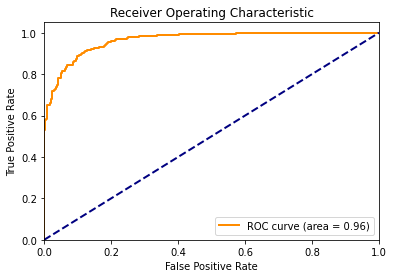

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Convert true_labels to binary format for ROC calculation
true_labels_binary = label_binarize(true_labels, classes=[0, 1])

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels_binary.ravel(), [prob[1] for prob in predicted_probs])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

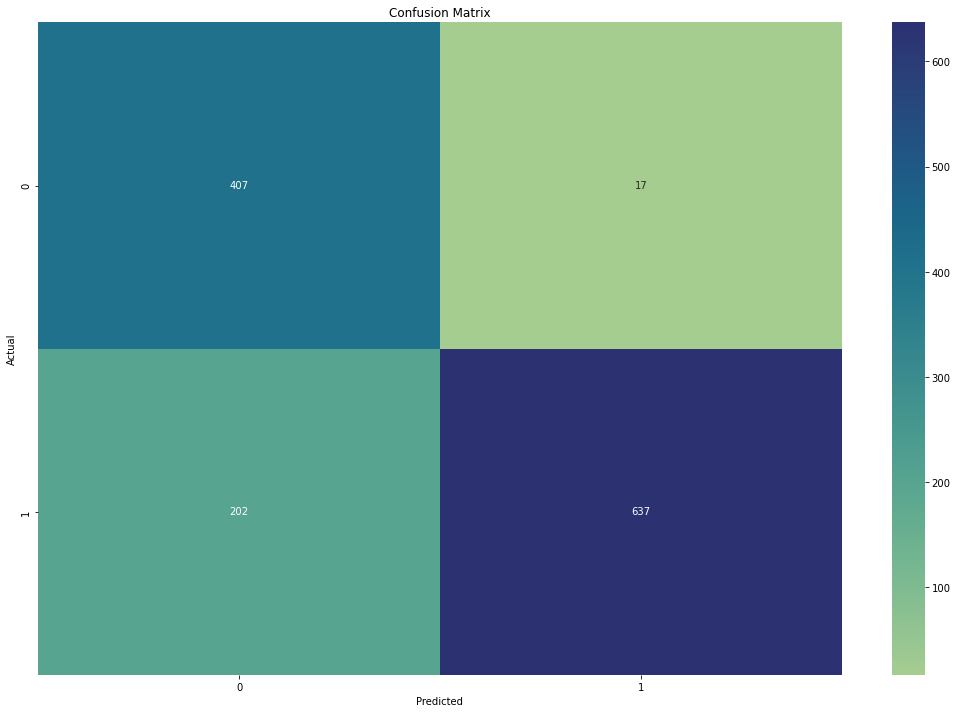

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
confusion = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(18, 12))
sns.heatmap(confusion, annot=True, fmt='d', cmap='crest')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

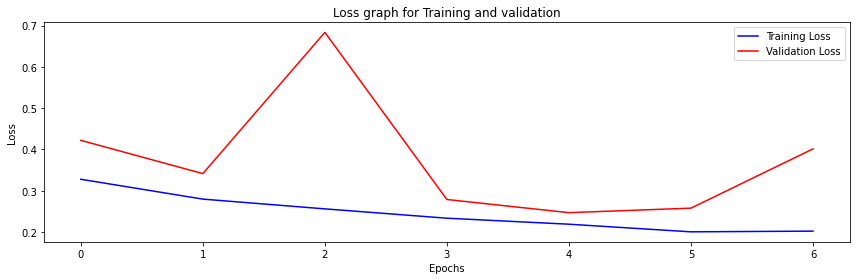

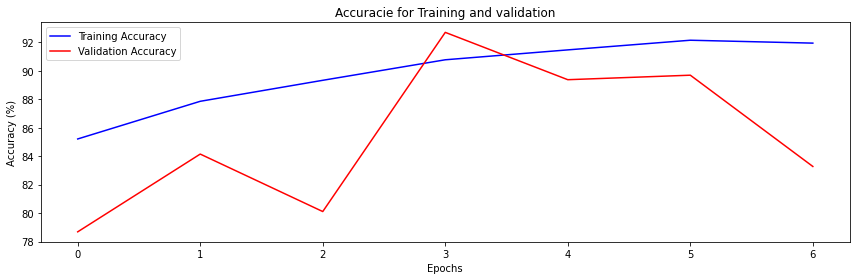

In [19]:
import matplotlib.pyplot as plt

# Determine the actual number of epochs run
actual_epochs = len(train_accuracies)
# Plot losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for Training and validation')

plt.tight_layout()
plt.show()


#Plot accuracies
plt.figure(figsize=(12, 4))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracie for Training and validation')

plt.tight_layout()
plt.show()